# Task 3 — Linear Regression (Simple & Multiple)

**Objective:** To implement and interpret linear regression models using scikit-learn. 

**What I'll do:** Load data, preprocess, split, fit LinearRegression, evaluate (MAE, MSE, RMSE, R²), inspect coefficients, check residuals, detect multicollinearity, save results and plots.

## 1. Importing necessary libraries & defining settings

In [2]:
# 1. Importing libarries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# Displaying settings
pd.set_option('display.max_columns', 200)
sns.set_style('whitegrid')
%matplotlib inline

# Making outputs folder
os.makedirs("outputs", exist_ok=True)

## 2. Loading dataset

In [3]:
df = pd.read_csv("Housing.csv")
df.columns = df.columns.str.strip()
print("Shape:", df.shape)
df.head()

Shape: (545, 13)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


## 3. Defining the target and features

In [23]:
# Setting the target column name
TARGET = "price"
y = df[TARGET]
X = df.drop(columns=[TARGET])

# Checking numeric and categorical columns
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric features:", num_cols)
print("Categorical features:", cat_cols)
X.head()

Numeric features: ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
Categorical features: ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']


,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


## 4. Correlation Heatmap

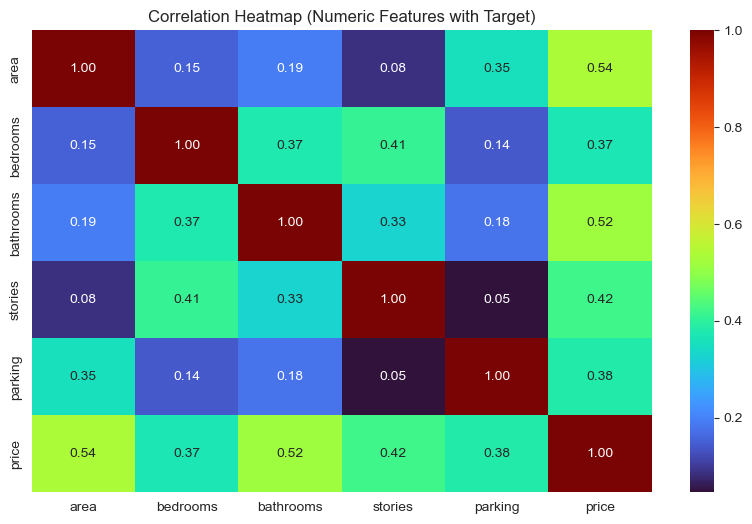

Correlation of numeric features with target (price):
price        1.000000
area         0.535997
bathrooms    0.517545
stories      0.420712
parking      0.384394
bedrooms     0.366494
Name: price, dtype: float64


In [21]:
num_features_for_corr = num_cols + [TARGET]

plt.figure(figsize=(10, 6))
corr_matrix = df[num_features_for_corr].corr()

sns.heatmap(corr_matrix, annot=True, cmap="turbo", fmt=".2f", cbar=True)
plt.title("Correlation Heatmap (Numeric Features with Target)")
plt.savefig("outputs/correlation_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# Sort correlations with target
print("Correlation of numeric features with target (price):")
print(corr_matrix[TARGET].sort_values(ascending=False))

## 5. Pairplot of the Top Correlated Features

Top 3 numeric features most correlated with price: ['area', 'bathrooms', 'stories']


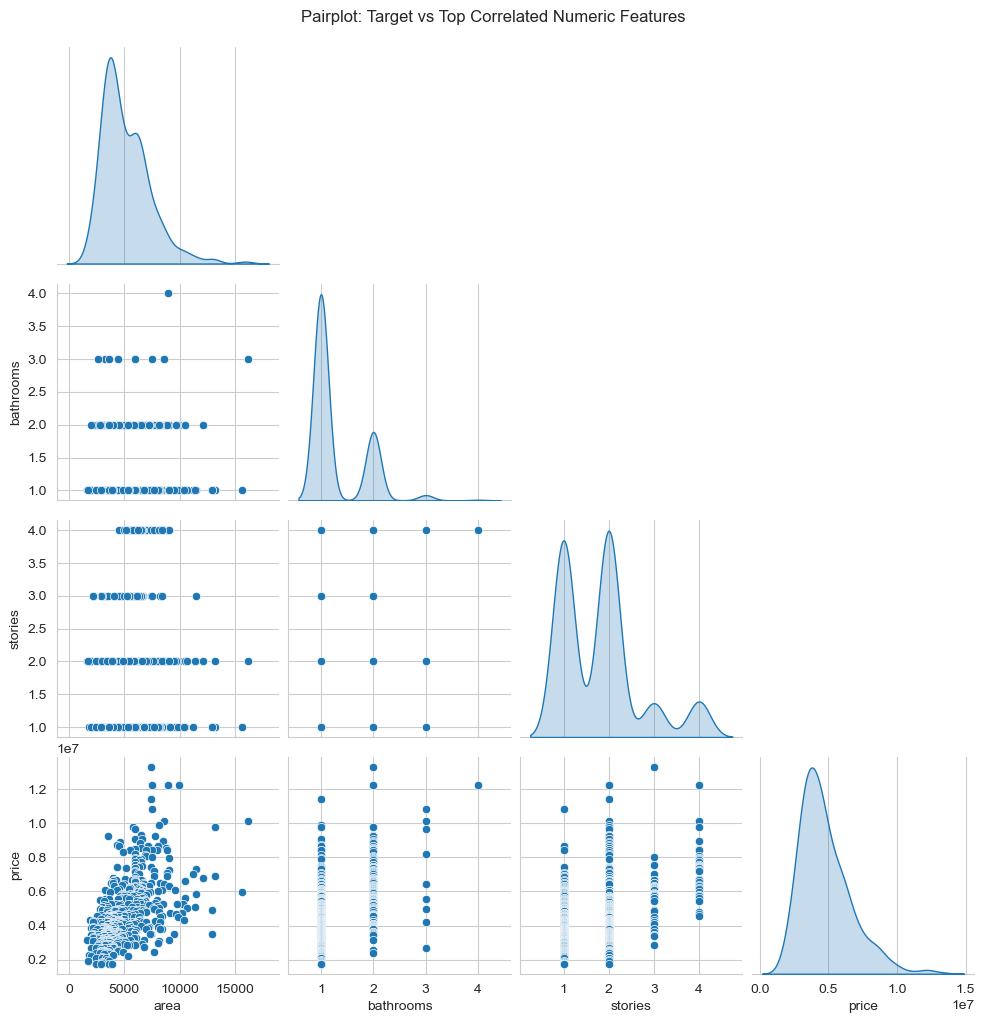

In [22]:
from seaborn import pairplot

# Getting the absolute correlations (except target itself)
corr_with_target = df[num_cols + [TARGET]].corr()[TARGET].drop(TARGET).abs()
top_features = corr_with_target.sort_values(ascending=False).head(3).index.tolist()

print("Top 3 numeric features most correlated with price:", top_features)

# Creating a smaller dataframe for pairplot
df_pair = df[top_features + [TARGET]].dropna()

sns.pairplot(df_pair, diag_kind="kde", corner=True)
plt.suptitle("Pairplot: Target vs Top Correlated Numeric Features", y=1.02)
plt.savefig("outputs/pairplot_top_features.png", dpi=300, bbox_inches='tight')
plt.show()

## 6. Simple Linear Regression Demo (One Feature)

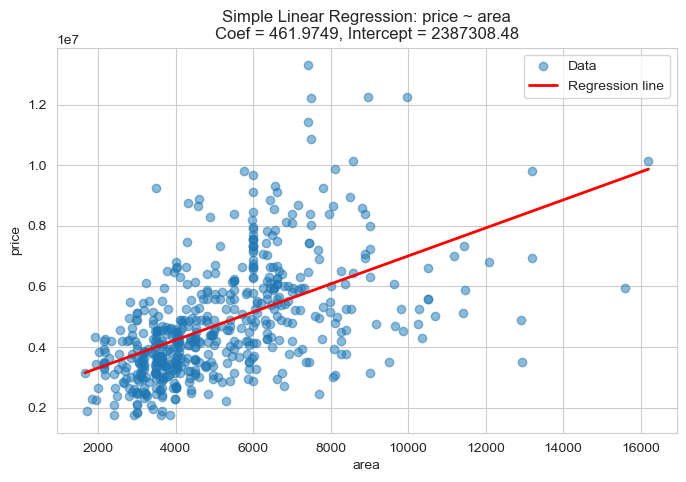

In [25]:
# Simple Linear Regression with one feature
SINGLE_FEATURE = "area"
df_sf = df[[SINGLE_FEATURE, TARGET]].dropna()
X_sf = df_sf[[SINGLE_FEATURE]].values.reshape(-1,1)
y_sf = df_sf[TARGET].values

model_sf = LinearRegression()
model_sf.fit(X_sf, y_sf)

# Predicting for line plot
y_sf_pred = model_sf.predict(X_sf)

# Plotting
plt.figure(figsize=(8,5))
plt.scatter(X_sf, y_sf, alpha=0.5, label="Data")
plt.plot(np.sort(X_sf.flatten()), y_sf_pred[np.argsort(X_sf.flatten())], 
         color='red', linewidth=2, label="Regression line")
plt.xlabel(SINGLE_FEATURE)
plt.ylabel(TARGET)
plt.title(f"Simple Linear Regression: {TARGET} ~ {SINGLE_FEATURE}\n"
          f"Coef = {model_sf.coef_[0]:.4f}, Intercept = {model_sf.intercept_:.2f}")
plt.legend()
plt.savefig(f"outputs/simple_regression_{SINGLE_FEATURE}_vs_{TARGET}.png", dpi=300, bbox_inches='tight')
plt.show()

## 7. Preprocessing Pipelines

In [33]:
numerical_features = ['area', 'bathrooms']
categorical_features = ['stories']

# Numeric pipeline: imputing missing + scale
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: imputing missing + one-hot encode
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Added the step name 'onehot' here
])

# Combine into a single preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, numerical_features),
    ('cat', cat_pipeline, categorical_features)
], remainder='passthrough')  # Keep remaining columns

# Now, your final pipeline will work correctly
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

## 8. Trains-Test Split & Model

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define transformers for different column types
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Create preprocessor with proper handling of categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Pipeline with preprocessor + linear regression
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Training the model
model_pipeline.fit(X_train, y_train)
print("Model trained successfully.")

Model trained successfully.


## 9. Model Evaluation

In [36]:
y_pred = model_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# Saving metrics
metrics = pd.DataFrame({
    "MAE": [mae],
    "MSE": [mse],
    "RMSE": [rmse],
    "R2": [r2]
})
metrics.to_csv("outputs/regression_metrics.csv", index=False)

MAE: 970043.40
MSE: 1754318687330.67
RMSE: 1324506.96
R²: 0.65


## 10. Coefficients

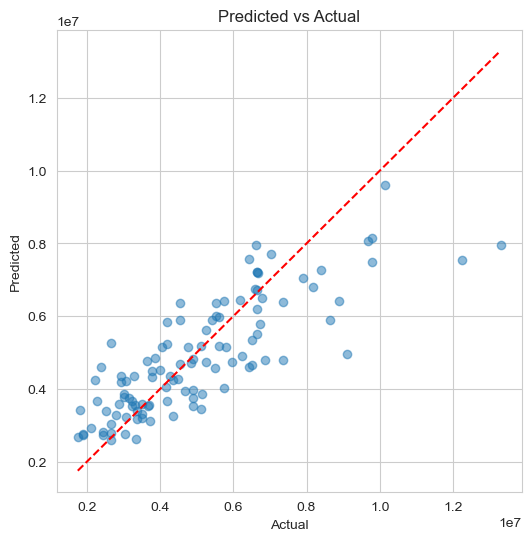

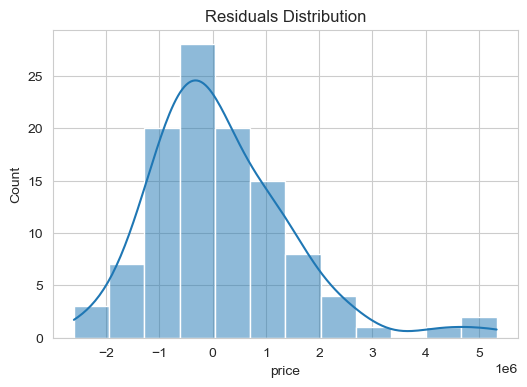

In [38]:
# Predicted vs Actual plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.savefig("outputs/predicted_vs_actual.png", dpi=300, bbox_inches='tight')
plt.show()

# Residuals distribution
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.savefig("outputs/residuals_hist.png", dpi=300, bbox_inches='tight')
plt.show()

## 12. Saving the Model

In [39]:
joblib.dump(model_pipeline, "outputs/linear_regression_pipeline.joblib")
print("Model saved as outputs/linear_regression_pipeline.joblib")

Model saved as outputs/linear_regression_pipeline.joblib
